### Imports 

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
num_total_event = 30  
rec_per_event = 15  # num. of recommendations per meal event in each run per patient.
all_patients = {1:'child#001', 2:'child#002', 3:'child#003', 4:'child#004', 5:'child#005',
                6:'child#006', 7:'child#007', 8:'child#008', 9:'child#009', 10: 'child#010',
                11:'adolescent#001', 12:'adolescent#002', 13:'adolescent#003', 14:'adolescent#004', 15:'adolescent#005',
                16:'adolescent#006', 17:'adolescent#007', 18:'adolescent#008', 19:'adolescent#009', 20:'adolescent#010',
                21:'adult#001', 22:'adult#002', 23:'adult#003', 24:'adult#004', 25:'adult#005',
                26:'adult#006', 27:'adult#007', 28:'adult#008', 29:'adult#009', 30:'adult#010'}
num_patient = len(all_patients)

ins_ceiling = 90
ins_spacing = 0.1
ins_space = np.arange(0, ins_ceiling + 10 + ins_spacing, ins_spacing)

noise_std = 5
global_tmi = 0
global_tmbg = 150

postbg_target = 112.5
bg_omin = 70
bg_omax = 180

In [6]:
def get_perf(data, key, low_lim=bg_omin, up_lim=bg_omax, target=postbg_target):
    '''
    Prints and returns the performance metrics.
    Perf.Metrics: Mean and Std. Dev of PP-BG. Hypo-, Hyper-, and Optimal Freqs. LBGI, HBGI, RI (risk indices)

    data (pandas.DataFrame): Data Frame with context, insulin recommendations, and corresponding BG values
    key (string): BG Measurements related to a key (e.g. bg_post_vol)
    low_lim, up_lim (float): low and high ends of the target range
    target (float): target postbg value
    '''
    bg_data = np.maximum(1, data.loc[:, key].to_numpy())

    mean = np.mean(bg_data)
    std = np.std(bg_data)
    hyper_freq = np.mean(bg_data > up_lim)
    hypo_freq = np.mean(bg_data < low_lim)
    optimal_freq = np.mean((bg_data <= up_lim) & (bg_data >= low_lim))

    fBG = 1.509 * (np.log(bg_data) ** 1.084 - 5.381)
    rbg = 10 * (fBG ** 2)
    rl = [bg if fBG[ind] < 0 else 0 for ind, bg in enumerate(rbg)]
    rh = [bg if fBG[ind] > 0 else 0 for ind, bg in enumerate(rbg)]
    LBGI = np.nan_to_num(np.mean(rl))
    HBGI = np.nan_to_num(np.mean(rh))
    RI = LBGI + HBGI

    print('\n{}\n==================='.format(key))
    print('Hyper range: {:.10f}'.format(hyper_freq))
    print('Hypo range: {:.10f}'.format(hypo_freq))
    print('Optimum range: {:.10f}'.format(optimal_freq))
    print('PostBG: {:.10f} +- {:.10f}'.format(mean, std))
    print('LBGI: {:.10f}, HBGI: {:.10f}, RI: {:.10f}\n'.format(LBGI, HBGI, RI))

    return mean, std, hyper_freq, hypo_freq, optimal_freq, LBGI, HBGI, RI

In [7]:
def print_perf(data, p_data_dict, keys, setup=False, index=-1, patient_list=all_patients):
    '''
        setup (string or bool): setup name (e.g. Single Meal Event (SME)), if False, do not print.
        index (int): data name for which the performance will be printed (-1 for all data and individuals together, 0 for all data, otherwise the patient index.)
        data (pandas.DataFrame): DataFrame containing the data of all patients.
        p_data_dict (dictionary): Keys are patient names (e.g. adult#001). Values are pandas.DataFrame objects for corresponding patients.
    '''
    if setup is not False:
        print('Setup: {}\n*******************\n'.format(setup))

    if index == -1:
        print_perf(data=data, keys=keys, p_data_dict=p_data_dict, index=0)
        for i in range(len(patient_list)):
            print_perf(data=data, keys=keys, p_data_dict=p_data_dict, index=[*patient_list.keys()][i])
    elif index == 0:
        print('OVERALL PERFORMANCE\n-------------------')
        for key in keys:
            _ = get_perf(data=data, key=key)
    else:
        print(patient_list[index])
        for key in keys:
            _ = get_perf(data=p_data_dict[patient_list[index]], key=key)

In [8]:
mme_path = 'MME/ppbg'
mme_data = pd.read_csv('./{}/mme_ppbg.csv'.format(mme_path))
mme_dict = {pt:pd.read_csv('./{}/{}_mme.csv'.format(mme_path, pt)) for pt in [*all_patients.values()]}

f_index = 1  # only first (1) recommendations
mme_dict_init = {pt:pd.read_csv('./{}/{}_mme.csv'.format(mme_path, pt)).loc[0:30*f_index-1, :] for pt in [*all_patients.values()]} 
mme_data_init = pd.concat(list(mme_dict_init.values()), ignore_index=True)

In [9]:
keys = ['SALE-LTS', 'LE-LTS', 'Tuned Calc.']
print_perf(data=mme_data, p_data_dict=mme_dict, setup='--', index=0, keys=keys) 
print('First Round')
print_perf(data=mme_data_init, p_data_dict=mme_dict_init, setup='--', index=0, keys=keys)

Setup: --
*******************

OVERALL PERFORMANCE
-------------------

SALE-LTS
Hyper range: 0.0005925926
Hypo range: 0.0000000000
Optimum range: 0.9994074074
PostBG: 114.9155122985 +- 10.1691481933
LBGI: 0.0817274964, HBGI: 0.1855354489, RI: 0.2672629453


LE-LTS
Hyper range: 0.0079259259
Hypo range: 0.0151111111
Optimum range: 0.9769629630
PostBG: 111.1227320608 +- 19.5779919200
LBGI: 0.7744880197, HBGI: 0.3385211453, RI: 1.1130091650


Tuned Calc.
Hyper range: 0.0000000000
Hypo range: 0.0014074074
Optimum range: 0.9985925926
PostBG: 123.3375641687 +- 17.7350519895
LBGI: 0.2368812690, HBGI: 0.7947591394, RI: 1.0316404084

First Round
Setup: --
*******************

OVERALL PERFORMANCE
-------------------

SALE-LTS
Hyper range: 0.0000000000
Hypo range: 0.0000000000
Optimum range: 1.0000000000
PostBG: 121.8717900401 +- 16.1403605123
LBGI: 0.1823476084, HBGI: 0.6470643449, RI: 0.8294119532


LE-LTS
Hyper range: 0.0633333333
Hypo range: 0.1244444444
Optimum range: 0.8122222222
PostBG: 11

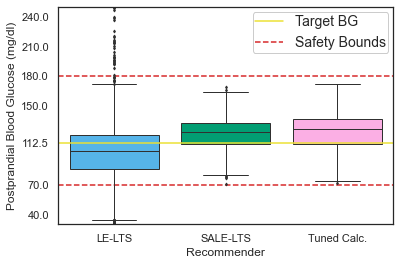

In [7]:
boxplot_data = mme_data_init.loc[:, {'LE-LTS', 'SALE-LTS', 'Tuned Calc.'}]
boxplot_data = boxplot_data.reindex(columns=['LE-LTS', 'SALE-LTS', 'Tuned Calc.'])

cp = sns.color_palette('colorblind')
cp2 = sns.color_palette('tab10')

sns.set_theme(style="white")

y_bins = np.array([40, 70, 112.5, 150, 180, 210, 240])

_, ax = plt.subplots()
ax.set_yticks(y_bins)
ax.set(ylim=(30, 250))
plt.rcParams['axes.formatter.useoffset'] = False

ax.axhline(y=postbg_target, linestyle='-', color=cp[8], alpha=1)
ax.axhline(y=bg_omin, linestyle='--', color=cp2[3], alpha=1)
ax.axhline(y=bg_omax, linestyle='--', color=cp2[3], alpha=1)

l3 = mlines.Line2D([], [], color=cp[8], ls='-', label='Target BG')
l4 = mlines.Line2D([], [], color=cp2[3], ls='--', label='Safety Bounds')

plt.legend(handles=[l3, l4], borderpad=0.2, facecolor='white', framealpha=1, loc=(0.58, 0.79), prop={'size': 14})
my_pal = {"SALE-LTS": cp[2], "LE-LTS": cp[9], "Tuned Calc.": cp[6]}
ax = sns.boxplot(data=boxplot_data, fliersize=2, linewidth=1, saturation=1, palette=my_pal, showfliers=True, width=0.8)
ax.set_ylabel('Postprandial Blood Glucose (mg/dl)')
ax.set_xlabel('Recommender')

plt.savefig('./figures/boxplot_init.pdf', bbox_inches='tight')

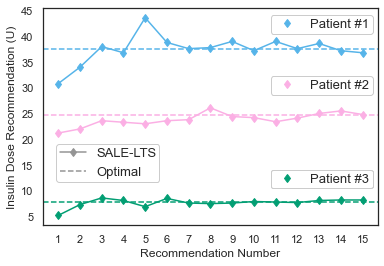

In [8]:
num_ev = num_total_event
color_ind = [6, 9, 2]

patient = ['adult#001', 'adult#009', 'adolescent#001']
meal_indices = [16, 16, 16]
optimal_doses = [24.7, 37.5, 7.8]
mme_rec = {m: np.array(mme_dict[patient[m]].loc[[*range(meal_indices[m], meal_indices[m] + (rec_per_event)*num_ev, num_ev)], 'ins_salelts']) for m in range(len(meal_indices))}

fig, ax = plt.subplots()
ax.set_xticks(np.arange(1, rec_per_event + 1))
ax.grid(False)

for i in range(len(meal_indices)):
    labels = ['_nolegend_', '_nolegend_', '_nolegend_'] if i > 0 else ['SME', 'MME', 'Optimal']
    ax.plot(np.arange(1, rec_per_event + 1), mme_rec[i], color=cp[color_ind[i]], alpha=1, label=labels[0], marker='d', linestyle='-')
    ax.axhline(optimal_doses[i], linestyle='--', color=cp[color_ind[i]], alpha=1, label=labels[2])

sns.set_style("white")

l1 = mlines.Line2D([], [], color=cp[7], marker='d', ls='-', label='SALE-LTS')
l2 = mlines.Line2D([], [], color=cp[7], marker='', ls='--', label='Optimal')

l3 = mlines.Line2D([], [], color=cp[9], marker='d', ls='', label='Patient #1')
l4 = mlines.Line2D([], [], color=cp[6], marker='d', ls='', label='Patient #2')
l5 = mlines.Line2D([], [], color=cp[2], marker='d', ls='', label='Patient #3')

leg1 = plt.legend(handles=[l1, l2], borderpad=0.25, facecolor='white', framealpha=1, loc=(0.04, 0.2), prop={'size': 13})
leg3 = plt.legend(handles=[l3], borderpad=0.25, facecolor='white', framealpha=1, loc=(0.68, 0.88), prop={'size': 13})
leg4 = plt.legend(handles=[l4], borderpad=0.25, facecolor='white', framealpha=1, loc=(0.68, 0.6), prop={'size': 13})
leg5 = plt.legend(handles=[l5], borderpad=0.25, facecolor='white', framealpha=1, loc=(0.68, 0.17), prop={'size': 13})

ax.add_artist(leg1)
ax.add_artist(leg3)
ax.add_artist(leg4)
ax.add_artist(leg5)

plt.xlabel('Recommendation Number')
plt.ylabel('Insulin Dose Recommendation (U)')

plt.savefig('./figures/comparison.pdf', bbox_inches='tight')

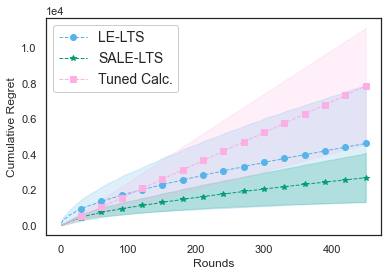

In [9]:
_, ax = plt.subplots()

run_count = num_total_event*rec_per_event
data = mme_data

pt_regrets_salelts_tc = {pt: np.array([*map(lambda x:(np.abs(data.loc[i*run_count:i*run_count + x, 'SALE-LTS-N'] - postbg_target) ).sum(), [*range(run_count)])]) for i, pt in enumerate(all_patients.values())}
pt_regrets_lelts_tc = {pt: np.array([*map(lambda x:(np.abs(data.loc[i*run_count:i*run_count + x, 'LE-LTS-N'] - postbg_target)).sum(), [*range(run_count)])]) for i, pt in enumerate(all_patients.values())}
pt_regrets_calc_tc = {pt: np.array([*map(lambda x:(np.abs(data.loc[i*run_count:i*run_count + x, 'Tuned Calc.-N'] - postbg_target)).sum(), [*range(run_count)])]) for i, pt in enumerate(all_patients.values())}

regret_sclts_tc = sum(pt_regrets_salelts_tc.values())/len(pt_regrets_salelts_tc)
regret_lelts_tc = sum(pt_regrets_lelts_tc.values())/len(pt_regrets_lelts_tc)
regret_calc_tc = sum(pt_regrets_calc_tc.values())/len(pt_regrets_calc_tc)

std_salets_tc = np.std(np.dstack(tuple(pt_regrets_salelts_tc.values())), axis=2, ddof=1).reshape(run_count)
std_lts_tc = np.std(np.dstack(tuple(pt_regrets_lelts_tc.values())), axis=2, ddof=1).reshape(run_count)
std_calc_tc = np.std(np.dstack(tuple(pt_regrets_calc_tc.values())), axis=2, ddof=1).reshape(run_count)

t = np.arange(run_count) + 1
i = [*range(29, run_count, 30)]
std_coeff = 1
sty = {
    'fillstyle': 'full',
    'linewidth': 1.0,
    'markevery': i}

sns.set_theme(style="white")
plt.ticklabel_format(style='sci', scilimits=(0,0), axis='y')

plt.plot(t, regret_lelts_tc, color=cp[9], marker='o', linestyle='--', **sty, label='LE-LTS')
plt.fill_between(t, regret_lelts_tc-std_coeff*std_lts_tc, regret_lelts_tc+std_coeff*std_lts_tc, color=cp[9], alpha=0.2)
plt.plot(t, regret_sclts_tc, color=cp[2], marker='*', linestyle='--', **sty, label='SALE-LTS')
plt.fill_between(t, regret_sclts_tc-std_coeff*std_salets_tc, regret_sclts_tc+std_coeff*std_salets_tc, color=cp[2], alpha=0.2)
plt.plot(t, regret_calc_tc, color=cp[6], marker='s', linestyle='--', **sty, label='Tuned Calc.')
plt.fill_between(t, regret_calc_tc-std_coeff*std_calc_tc, regret_calc_tc+std_coeff*std_calc_tc, color=cp[6], alpha=0.2)

plt.legend(loc='upper left', facecolor='white', framealpha=1, prop={'size':14})
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')

plt.savefig('./figures/regret.pdf', bbox_inches='tight')

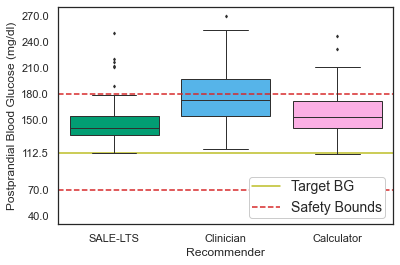

In [10]:
cli_pt = {22:'adult#002', 25:'adult#005', 27:'adult#007', 28:'adult#008', 30:'adult#010'}
clinician_data = pd.read_csv('./clinician_comparison/test_res/test_res.csv')
clinician_dict = {pt:pd.read_csv('./clinician_comparison/test_res/test_res_{}.csv'.format(pt)) for pt in cli_pt.values()}
boxplot_data = clinician_data.loc[:, {'meal', 'patient', 'bg_fasting', 'SALE-LTS', 'Clinicians', 'Calculator'}]
boxplot_data = boxplot_data.rename(columns={'Clinicians':'Clinician'})
boxplot_data = pd.melt(boxplot_data, id_vars=['patient', 'meal', 'bg_fasting'], value_vars=['SALE-LTS', 'Clinician', 'Calculator'], var_name='Method', value_name='Postprandial Blood Glucose (mg/dl)')

sns.set_theme(style="white")
y_bins = np.array([40, 70, 112.5, 150, 180, 210, 240, 270])
_, ax = plt.subplots()
ax.set_yticks(y_bins)
ax.set(ylim=(30, 280))
plt.rcParams['axes.formatter.useoffset'] = False

ax.axhline(y=postbg_target, linestyle='-', color=cp2[8], alpha=1)
ax.axhline(y=bg_omin, linestyle='--', color=cp2[3], alpha=1)
ax.axhline(y=bg_omax, linestyle='--', color=cp2[3], alpha=1)

l3 = mlines.Line2D([], [], color=cp2[8], ls='-', label='Target BG')
l4 = mlines.Line2D([], [], color=cp2[3], ls='--', label='Safety Bounds')

plt.legend(handles=[l3, l4], borderpad=0.2, loc=[0.57,0.03], facecolor='white', framealpha=1, prop={'size': 14})

my_pal = {"SALE-LTS": cp[2], "Clinician": cp[9], "Calculator": cp[6]}
ax = sns.boxplot(x="Method", y="Postprandial Blood Glucose (mg/dl)", data=boxplot_data, fliersize=2, linewidth=1, saturation=1, palette=my_pal, showfliers=True)
ax.set_xlabel('Recommender')

plt.savefig("./figures/doc_comp.pdf", bbox_inches='tight')

In [11]:
keys = ['SALE-LTS', 'Clinicians', 'Calculator']
print_perf(data=clinician_data, p_data_dict=clinician_dict, setup='--', index=0, keys=keys, patient_list=cli_pt) 

Setup: --
*******************

OVERALL PERFORMANCE
-------------------

SALE-LTS
Hyper range: 0.0700000000
Hypo range: 0.0000000000
Optimum range: 0.9300000000
PostBG: 147.9603778524 +- 26.9429452030
LBGI: 0.0000044436, HBGI: 3.2408832107, RI: 3.2408876543


Clinicians
Hyper range: 0.4200000000
Hypo range: 0.0000000000
Optimum range: 0.5800000000
PostBG: 176.8460689764 +- 35.3176282499
LBGI: 0.0000000000, HBGI: 7.9009966721, RI: 7.9009966721


Calculator
Hyper range: 0.1800000000
Hypo range: 0.0000000000
Optimum range: 0.8200000000
PostBG: 158.2623413944 +- 27.2472407932
LBGI: 0.0000800138, HBGI: 4.6442604232, RI: 4.6443404370



#### Figure 1

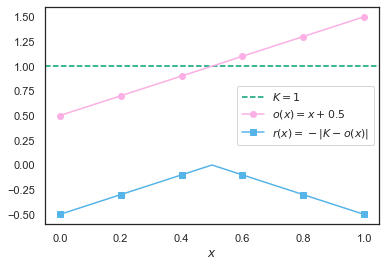

In [12]:
K = 1  # target value
a, b = 1, 0.5  # true theta
x = np.linspace(0, 1, 101)  # action (arm) space
ox = a * x + b  # outcome function
rx = -np.abs(K - ox)  # reward function

plt.figure()
plt.axhline(K, linestyle='--', color=cp[2], label=r'$K = 1$')
plt.plot(x, ox, marker='o', markevery=20, color=cp[6], label=r'$o(x) = x + 0.5$')
plt.plot(x, rx, marker='s', markevery=20, color=cp[9],  label=r'$r(x) = -|K - o(x)|$')
plt.xlabel(r'$x$')
plt.legend()
plt.savefig('./figures/fig1.pdf', bbox_inches='tight')

In [26]:
nomeal_data = pd.read_csv('./{}/nomeal_all_ppbg.csv'.format(mme_path))
ins_recs = [*nomeal_data['ins_salelts']]
np.sum(ins_recs)

0.0